Based on Kaggle python3 docker image.
For more explaintation:
https://www.kaggle.com/junxiangji/lstm-sentiment-analysis-keras/edit 


In [108]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [109]:
data1 = pd.read_csv('./data/Sentiment.csv')
# Keeping only the neccessary columns
data = data1[['text','sentiment']]

In [110]:
%matplotlib inline
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
data[0:9]
# data.dtypes

# data[data.sentiment.isnull()]

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative
7,Going on #MSNBC Live with @ThomasARoberts arou...,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative


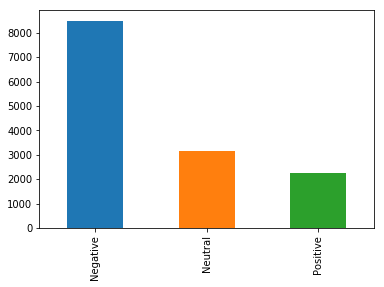

In [111]:
data.sentiment.value_counts().plot(kind="bar")

In [112]:
# data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

# Why size and shape are not same?
print(data.size)
print(data.shape)
#print(data.tail)
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
#tokenizer.word_counts
tokenizer.word_index # index started from 1 not 0.
X[0:2] # type is list


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4472
16986
27742
(13871, 2)


{'gopdebate': 1,
 'the': 2,
 'gopdebates': 3,
 'to': 4,
 'of': 5,
 'is': 6,
 'a': 7,
 'and': 8,
 'i': 9,
 'in': 10,
 'rwsurfergirl': 11,
 'you': 12,
 'for': 13,
 'it': 14,
 'trump': 15,
 'on': 16,
 'that': 17,
 'fox': 18,
 'this': 19,
 'not': 20,
 'was': 21,
 'about': 22,
 'realdonaldtrump': 23,
 'debate': 24,
 'amp': 25,
 'from': 26,
 'at': 27,
 'news': 28,
 'last': 29,
 'we': 30,
 'have': 31,
 'be': 32,
 'candidates': 33,
 'me': 34,
 'are': 35,
 'but': 36,
 'he': 37,
 'just': 38,
 'they': 39,
 'gop': 40,
 'so': 41,
 'with': 42,
 'like': 43,
 'what': 44,
 'who': 45,
 'up': 46,
 'my': 47,
 'all': 48,
 'megynkelly': 49,
 'dont': 50,
 'night': 51,
 'how': 52,
 'people': 53,
 'if': 54,
 'as': 55,
 'foxnews': 56,
 'has': 57,
 'jeb': 58,
 'bush': 59,
 'one': 60,
 'no': 61,
 'do': 62,
 'by': 63,
 'when': 64,
 'out': 65,
 'their': 66,
 'can': 67,
 'would': 68,
 'think': 69,
 'will': 70,
 'im': 71,
 'more': 72,
 'or': 73,
 'get': 74,
 'his': 75,
 'republican': 76,
 'president': 77,
 'did': 78,

[[52, 78, 341, 456, 22, 2, 420, 365, 95, 29, 51, 1039, 1],
 [351,
  125,
  1954,
  2,
  597,
  1,
  29,
  51,
  228,
  35,
  198,
  5,
  175,
  1417,
  10,
  1577,
  1356,
  847]]

In [113]:
 # type is array and we prefixed with zeros. This should be masked in model
X = pad_sequences(X)

print(X.shape)
X[0:2]

(13871, 28)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   52,   78,  341,  456,   22,    2,  420,
         365,   95,   29,   51, 1039,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  351,
         125, 1954,    2,  597,    1,   29,   51,  228,   35,  198,    5,
         175, 1417,   10, 1577, 1356,  847]], dtype=int32)

JIM: can remove **stop words**

For the following Embeding layer. The input is the sequence of words, and the out put will has one more dimation.
Which is because now one word previously is represented as a number now become a vector (word embeding)

Ref
https://stackoverflow.com/questions/46155868/keras-embedding-layer

https://keras.io/layers/embeddings/

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [114]:
embed_dim = 128
lstm_out = 196

model = Sequential()

# TODO: consider using mask_zero=True

model.add(Embedding(max_fatures, embed_dim,mask_zero="Ture", input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
Y = pd.get_dummies(data['sentiment']).values

# negetive, neutral, pos
Y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9293, 28) (9293, 3)
(4578, 28) (4578, 3)


# Train

In [117]:
batch_size = 52
model.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, verbose = 2)

Epoch 1/100
 - 21s - loss: 0.8572 - acc: 0.6331
Epoch 2/100
 - 19s - loss: 0.7220 - acc: 0.6928
Epoch 3/100
 - 20s - loss: 0.6519 - acc: 0.7313
Epoch 4/100
 - 22s - loss: 0.6128 - acc: 0.7483
Epoch 5/100
 - 19s - loss: 0.5756 - acc: 0.7646
Epoch 6/100
 - 20s - loss: 0.5563 - acc: 0.7726
Epoch 7/100
 - 22s - loss: 0.5300 - acc: 0.7847
Epoch 8/100
 - 18s - loss: 0.5052 - acc: 0.7975
Epoch 9/100
 - 18s - loss: 0.4831 - acc: 0.8043
Epoch 10/100
 - 18s - loss: 0.4684 - acc: 0.8115
Epoch 11/100
 - 18s - loss: 0.4435 - acc: 0.8241
Epoch 12/100
 - 19s - loss: 0.4264 - acc: 0.8289
Epoch 13/100
 - 18s - loss: 0.4168 - acc: 0.8336
Epoch 14/100
 - 18s - loss: 0.4034 - acc: 0.8431
Epoch 15/100
 - 22s - loss: 0.3851 - acc: 0.8450
Epoch 16/100
 - 20s - loss: 0.3772 - acc: 0.8460
Epoch 17/100
 - 18s - loss: 0.3631 - acc: 0.8526
Epoch 18/100
 - 21s - loss: 0.3556 - acc: 0.8583
Epoch 19/100
 - 19s - loss: 0.3450 - acc: 0.8598
Epoch 20/100
 - 19s - loss: 0.3273 - acc: 0.8712
Epoch 21/100
 - 19s - loss: 0

In [118]:

model.save('whole_model_100_round_with_neutral.h5')

In [119]:
from keras.models import load_model
model = load_model('whole_model_100_round_with_neutral.h5')

# Validation

In [120]:
validation_size = 1500

X_validate = X_test[-validation_size:]
print(X_validate.shape)
Y_validate = Y_test[-validation_size:]
print(Y_validate.shape)
X_test = X_test[:-validation_size]
print(X_test.shape)
Y_test = Y_test[:-validation_size]
print(Y_test.shape)

score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

(1500, 28)
(1500, 3)
(3078, 28)
(3078, 3)
score: 2.44
acc: 0.65


In [121]:
pos_cnt, neg_cnt, neu_cnt, pos_correct, neu_correct, neg_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
#         print("Y_validate[x] - ", Y_validate[x], ", argmax - ", np.argmax(Y_validate[x]) )
        if np.argmax(Y_validate[x]) == 0: # argmax reture the _index_: 0 - neg, 1 - neu, 2 - positive 
            neg_correct += 1
        elif np.argmax(Y_validate[x]) == 1:
            neu_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    if np.argmax(Y_validate[x]) == 1:
        neu_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neu_acc", neu_correct/neu_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")


pos_acc 10.129870129870131 %
neu_acc 36.811594202898554 %
neg_acc 79.27232635060639 %


# Prediction

In [130]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
# twt = ['all']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]

print(model.predict_proba(twt,batch_size=1,verbose = 2))

if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutral")
elif (np.argmax(sentiment) == 2):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  204  724    5  130    6   55 1101   55   48    5  130]]
[[9.9445081e-01 5.5492623e-03 9.0782839e-09]]
negative


# TODO

This can be further tweaked by 
* remove @someone in the tweets.
* remove stop words.
* use word2vec.
* change the LSTM to Dense and change the parameter.
* give emoticons more importance.
* Boosting - Observed that having an extra `neutral` category would greatly decrease `positive` acc (much worse than randomly perdition which should have 30% acc) and predition for neutral is as bad random perdiction. We need to only train the model for `positive` and `neutral` and then ensamble them togather. 